# Constructing Isosurface and Electrostatic Property from Chemtools.

Assumes python 2, chemtools and scikit.image is installed.

The process is as follows:
1. Construct a cube around the molecule coordinate.
2. Compute the electron density at each point in the cube.
3. Run marching cubes algorithm on the cube for a specific isosurface.
4. Shift the vertices so that they're position is correct.
5. Save the vertices, triangles and property (Electrostatic potential) for mayavi.

INFO: Initialized cube: <class 'chemtools.utils.cube.UniformGrid'>
INFO: Origin : [-5.69406138 -6.79999805 -5.0999987 ]
INFO: Axes 1 : [ 2.00000000e-01 -4.74943009e-08 -4.71652787e-08]
INFO: Axes 2 : [4.74943022e-08 2.00000000e-01 5.76449346e-09]
INFO: Axes 3 : [ 4.71652773e-08 -5.76450465e-09  2.00000000e-01]
INFO: Shape  : [67 68 51]


Initialized: <horton.gbasis.cext.GOBasis object at 0x7fd75bd5f4b0>
  Number of basis functions         : 138
  Number of normalization constants : 198
  Maximum shell type                : 3
  Center     0 :  S7 S6 S1 S1 S1 P3 P1 P1 P1 Dp1 Dp1 Dp1 Fp1 Fp1
  Center     1 :  S7 S6 S1 S1 S1 P3 P1 P1 P1 Dp1 Dp1 Dp1 Fp1 Fp1
  Center     2 :  S3 S1 S1 S1 P1 P1 P1 Dp1 Dp1
  Center     3 :  S3 S1 S1 S1 P1 P1 P1 Dp1 Dp1



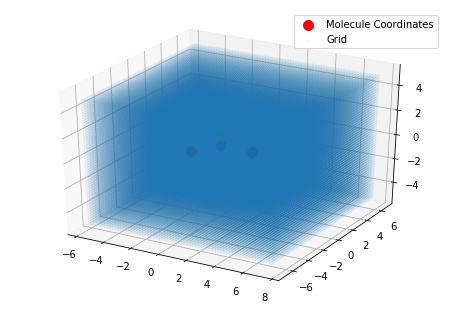

('Number of Points ', 232356)


In [5]:
%matplotlib inline
import numpy as np
from chemtools.wrappers import Molecule  # Compute electron density
from chemtools.utils.cube import UniformGrid  # Constructing the cube
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Need this to plot in 3D

mol = Molecule.from_file("./data/ch2o_q+0.fchk")
grid = UniformGrid.from_molecule(mol, spacing=0.2, extension=5.0, rotate=True)
coords = mol.coordinates

# Plot the cubic grid
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c="r", s=100, label="Molecule Coordinates")
ax.scatter(grid.points[:, 0], grid.points[:, 1], grid.points[:, 2], s=1, label="Grid",
           alpha=0.1)
plt.legend()
plt.show()

print("Number of Points ", grid.points.shape[0])

In [6]:
# Save the cube points as .npy file, optional, suitable if you want to use python 3 for marching cubes.
# np.save("cube_ch2o_points.npy", grid.points)

# Compute the electron density
density = mol.compute_density(grid.points)

# How to write a cube file
# grid.generate_cube("./data/ch2o_density.cube", density)

# If you want to use python 3 only, then save density using .npy
# np.save("cube_ch2o_density.npy, density)

## Attempting to do Marching Cubes.

If one wants to use python 3, then you'll need to save "grid.points" and "density" as npy and load them using np.load

Here, we assume the other option.

Making sure density has the right isosurface values 0.010000
[0.00996823 0.01004633 0.01001293 ... 0.00979318 0.00979318 0.00988851]


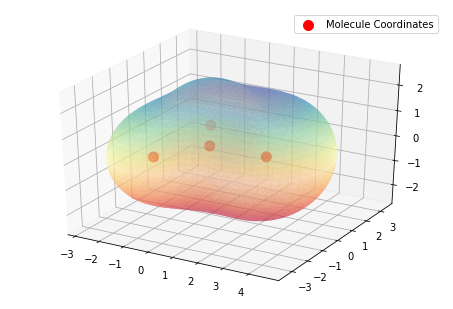

In [7]:
from skimage import measure

# Construct the vertices and triangles from the marching cube algorithm from scikit.image
density = density.reshape((grid.shape))
step_size = np.diagonal(grid.axes)
isosurface = 0.01  # Value of isosurface
verts, triangles, _, _ = measure.marching_cubes_lewiner(density, isosurface)
verts = np.array(verts, dtype=np.float)

# Need to shift the vertices, so that it has the correct position.
verts = grid.origin + verts * step_size

# Making sure that electron density at the vertices closely match the isosurface value
print("Making sure density has the right isosurface values %f" % isosurface)
print(mol.compute_density(verts))

# Plotting triangle mesh https://matplotlib.org/3.1.0/gallery/mplot3d/trisurf3d_2.html
#   Just to quickly plot to make sure everything is fine.
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=triangles, cmap=plt.cm.Spectral,
                alpha=0.5)
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c="r", s=100, label="Molecule Coordinates")
plt.legend()
plt.show()

Now that we know we have the correct isosurface, it is time to calculate the electrostatic potential.

In [ ]:
esp = mol.compute_esp(verts)
np.save("./data/ch2o_esp.npy", esp)
np.save("./data/ch2o_vertices.npy", verts)
np.save("./data/ch2o_triangles.npy", triangles)
print("Save Vertices, Triangles and the Property: Electrostatic. Done")